<a href="https://colab.research.google.com/github/bongkyunSON/Deep_Leaning/blob/main/Prophet_case7_230105.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import necessary libraries
import numpy as np # linear algebra
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
warnings.filterwarnings('ignore')  # Hide warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)
import datetime as dt
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
from plotnine import *
import io
# we'll use the statistics package to conduct some predictive analytics
import statistics as st
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DataFrame
from pandas import to_datetime
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from  sklearn.metrics import mean_absolute_error

In [2]:
# Let's convert the datafile into a dataframe
# Put the csv filename as filename
filename = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/prophet_강의/data/gold_monthly_csv.csv'
df = pd.read_csv(filename) # important to specify encoding

In [3]:
# check total number of cells, first few rows, and descriptive stats 
def descriptive_info(df):
#  number_of_cells = df.count(axis=0, level=None, numeric_only=False)
  # Let's check the shape of the dataset
  print('Features:', df.shape[1], ' ', 'Entries:', df.shape[0])
  print('\n\n')
  print('Printing descriptive statistics...\n\n', df.describe())

In [4]:
# now check some basic info of our dataset
descriptive_info(df)

Features: 2   Entries: 847



Printing descriptive statistics...

              Price
count   847.000000
mean    416.556906
std     453.665313
min      34.490000
25%      35.190000
50%     319.622000
75%     447.029000
max    1840.807000


In [5]:
# Let's define a function to check the type of our features and check for 
# missing values in our dataset
def missing_val(df):
  print(df.info())
  print('\n\nFeatures with missing values in descending order \n\n')
  print((df.isnull().sum()/ df.shape[0]).sort_values(ascending=False))

In [6]:
# Now apply the missing_val function
missing_val(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847 entries, 0 to 846
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    847 non-null    object 
 1   Price   847 non-null    float64
dtypes: float64(1), object(1)
memory usage: 13.4+ KB
None


Features with missing values in descending order 


Date     0.0
Price    0.0
dtype: float64


In [7]:
# This Function is to prepare the dataset for Fb Prophet
#ds, save the name of date column as ds
#y, save the name of column we are interested in as y
def prepare_data(df, ds, y):
  '''
  input: df = dataframe
  ds = date column
  y = prediction column
  '''
  df = df[[ds, y]]
  df = df.rename(columns={ds: "ds", y: "y"}) #now it is usable for FB Prophet, let's check the new file
  print('The series is ready for use.\n')
  return df

In [8]:
# Use the function to prepare the dataframe to feed into fbprophet
# df = series, ds = the time variable name from the dataframe (string), 
# y = intended variable name for prediction from the dataframe, (string)
df2 = prepare_data(df, ds = 'Date', y = 'Price') 
print(df2.head())
print('')
print('The length of your series is: ', len(df2))

The series is ready for use.

        ds      y
0  1950-01  34.73
1  1950-02  34.73
2  1950-03  34.73
3  1950-04  34.73
4  1950-05  34.73

The length of your series is:  847


In [9]:
## function to Plot the prepared data
def _fig_plot(df, X, Y):
  ''' Function plots the data. requires to provide dataframe in the
  format of date as ds, observation as y, Preset other variables e.g., axis name
  '''
  df.plot(x = X, y = Y, figsize=Figsize, label = Label)
  plt.xlabel(xAxisLabel, fontsize = 16)
  plt.ylabel(yAxisLabel, fontsize = 16)
  plt.legend()
  plt.title(Title, fontsize = 20)
  ax = plt.gca().get_xaxis()

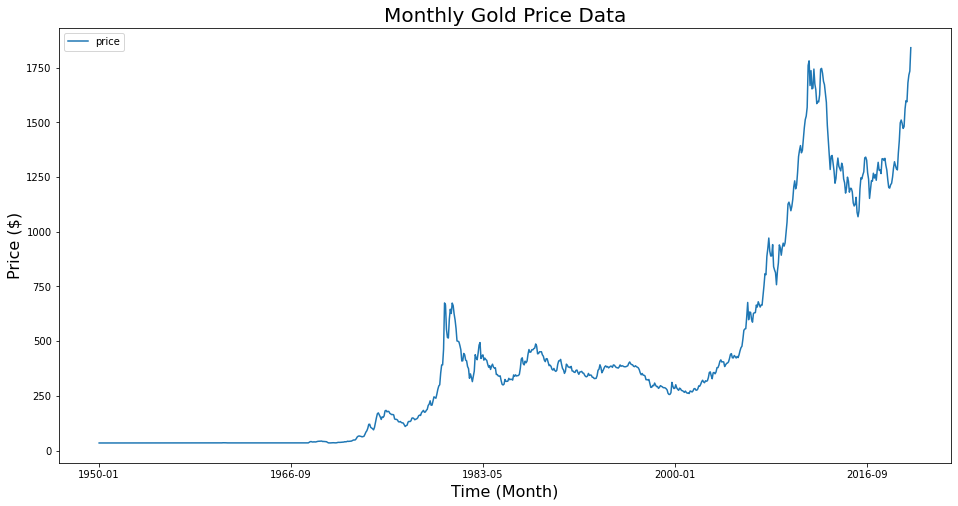

In [10]:
# provide variable names and other required inputs to plot using the function
X = 'ds'
Y = 'y'
Label = "price"
Figsize = (16,8)
Title = "Monthly Gold Price Data"
xAxisLabel = 'Time (Month)'
yAxisLabel = 'Price ($)'
_fig_plot(df2, X, Y)

In [11]:
# let's plot a short window to visualize better
shortX = df2[['ds', 'y']].tail(90)
shortX = shortX.rename(columns = {'ds': 'dss', 'y':'yss'}) 
#shortY = df2.loc[shortX]
shortX.head()
#print(len(shortX), len(shortY))

,dss,yss
757,2013-02,1630.688
758,2013-03,1591.013
759,2013-04,1485.905
760,2013-05,1416.143
761,2013-06,1342.700


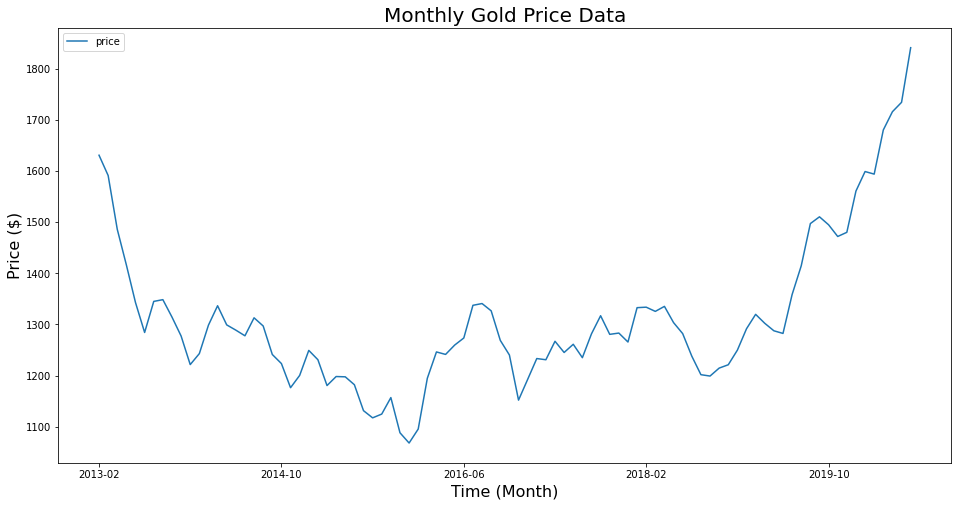

In [12]:
# provide variable names and other required inputs to plot using the function
X = 'dss'
Y = 'yss'
Label = "price"
Figsize = (16,8)
Title = "Monthly Gold Price Data"
xAxisLabel = 'Time (Month)'
yAxisLabel = 'Price ($)'
_fig_plot(shortX, X, Y)

In [13]:
# define training dataset
train = df2.copy()

In [14]:
# let's predict now
# instantiate the model and fit the timeseries

prophet = Prophet(daily_seasonality= 'auto',
                  weekly_seasonality='auto',
                  yearly_seasonality= False, 
                  growth='linear', 
                  changepoints=None, 
                  n_changepoints=25, 
                  changepoint_range=0.8,  
                  holidays=None, 
                  seasonality_prior_scale=20, 
#                  holidays_prior_scale=10, 
                  changepoint_prior_scale=0.05, 
                  mcmc_samples=0, 
                  interval_width=0.8, 
                  uncertainty_samples=1000, 
                  stan_backend=None)
prophet.add_seasonality(name='yearly', period=365, fourier_order=3, 
                      mode = 'multiplicative')
prophet.fit(train)


# create a future data frame 
future = prophet.make_future_dataframe(periods=12, freq = 'MS')
forecast = prophet.predict(future)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuo9lzm2t/qzh3mq3d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuo9lzm2t/6z_s49kh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54467', 'data', 'file=/tmp/tmpuo9lzm2t/qzh3mq3d.json', 'init=/tmp/tmpuo9lzm2t/6z_s49kh.json', 'output', 'file=/tmp/tmpuo9lzm2t/prophet_modelb0eire52/prophet_model-20230105142625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:26:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:26:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Printing outputs from Prophet prediction...
           ds       yhat  yhat_lower  yhat_upper
0 1950-01-01  22.911738 -150.028377  192.884479
1 1950-02-01  23.388047 -151.650401  184.999834
2 1950-03-01  23.600549 -157.845940  199.565638
3 1950-04-01  23.520417 -145.336128  199.242338
4 1950-05-01  23.453236 -148.966245  193.351712


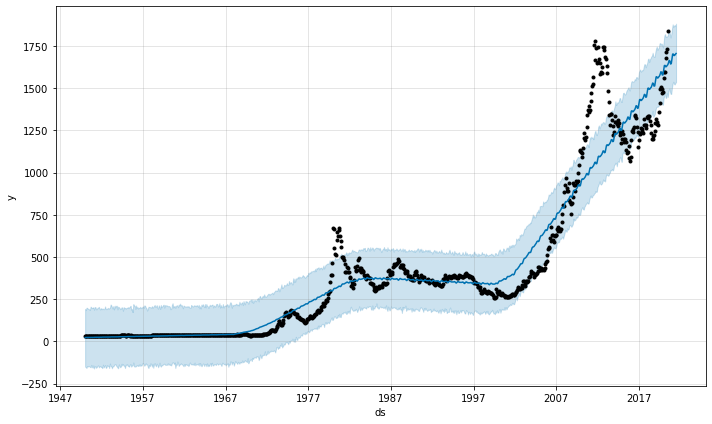

In [15]:
# summarize the forecast
print('Printing outputs from Prophet prediction...\n', forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# plot forecast
prophet.plot(forecast)
plt.show()

In [16]:
# Python
plot_plotly(prophet, forecast)

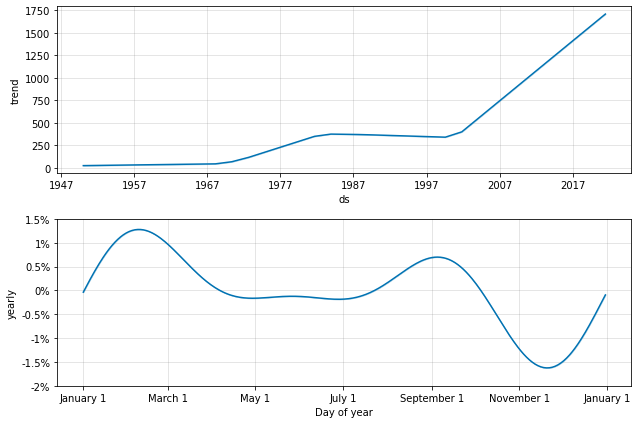

In [17]:
# plot the components of forcasted series
fig2 = prophet.plot_components(forecast)
plt.show()

In [18]:
len(df2)

847

In [19]:
# use built in fbprophet evaluation function and metrix
evaluation_model = cross_validation(prophet, initial='400 days', period='60 days', horizon = '30 days')

INFO:prophet:Making 420 forecasts with cutoffs between 1951-03-06 00:00:00 and 2020-06-01 00:00:00


  0%|          | 0/420 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 11.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuo9lzm2t/boj3dzvx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuo9lzm2t/5elhcpb7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54853', 'data', 'file=/tmp/tmpuo9lzm2t/boj3dzvx.json', 'init=/tmp/tmpuo9lzm2t/5elhcpb7.json', 'output', 'file=/tmp/tmpuo9lzm2t/prophet_model6y47p0c1/prophet_model-20230105142704.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
14:27:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 12.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuo9lzm2t/swyaid0u.json
DEBUG:cmdstanpy:input tempfil

In [20]:
evaluation_metrix = performance_metrics(evaluation_model)
evaluation_metrix.sort_values('rmse').head(5)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
22,25 days,16663.889269,129.088688,82.341638,0.174996,0.098193,0.172266,0.478571
21,24 days,17817.543027,133.482370,82.797526,0.158185,0.092737,0.163890,0.501984
17,20 days,20288.676019,142.438324,83.177482,0.139963,0.091967,0.142664,0.488095
26,29 days,21041.684550,145.057522,92.699231,0.174664,0.100998,0.192038,0.492674
20,23 days,22853.724931,151.174485,92.163739,0.154023,0.091582,0.163413,0.480159
